In [1]:
# 📦 STEP 1: Import necessary libraries for regression-based prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Text processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocessing and modeling tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ANN (for regression)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KORISNIK/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# 📥 STEP 2: Load reviews and product metadata, and merge them

# First, I load and concatenate all review chunks
review_files = [
    "../data/reviews_0-250.csv",
    "../data/reviews_250-500.csv",
    "../data/reviews_500-750.csv",
    "../data/reviews_750-1250.csv",
    "../data/reviews_1250-end.csv"
]

# Load and combine review files
review_dfs = [pd.read_csv(file) for file in review_files]
reviews_df = pd.concat(review_dfs, ignore_index=True)

# Now I load product metadata
products_df = pd.read_csv("../data/product_info.csv")

# Check the structure of both DataFrames
print("🧾 Reviews shape:", reviews_df.shape)
print("🛍️ Products shape:", products_df.shape)

# Merge both on the shared 'product_id'
merged_df = pd.merge(reviews_df, products_df, on='product_id', how='inner')

# Preview the merged dataset
# ✅ Updated preview using correct column names from the merged dataset
merged_df[['review_text', 'rating_x', 'brand_name_x', 'price_usd_x', 'primary_category']].head()



C:\Users\KORISNIK\AppData\Local\Temp\ipykernel_10972\1203647153.py:13: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  review_dfs = [pd.read_csv(file) for file in review_files]
C:\Users\KORISNIK\AppData\Local\Temp\ipykernel_10972\1203647153.py:13: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  review_dfs = [pd.read_csv(file) for file in review_files]
C:\Users\KORISNIK\AppData\Local\Temp\ipykernel_10972\1203647153.py:13: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  review_dfs = [pd.read_csv(file) for file in review_files]


🧾 Reviews shape: (1094411, 19)
🛍️ Products shape: (8494, 27)


,review_text,rating_x,brand_name_x,price_usd_x,primary_category
0,I use this with the Nudestix “Citrus Clean Bal...,5,NUDESTIX,19.0,Skincare
1,I bought this lip mask after reading the revie...,1,LANEIGE,24.0,Skincare
2,My review title says it all! I get so excited ...,5,LANEIGE,24.0,Skincare
3,I’ve always loved this formula for a long time...,5,LANEIGE,24.0,Skincare
4,"If you have dry cracked lips, this is a must h...",5,LANEIGE,24.0,Skincare


In [5]:
# 🧼 STEP 3: Clean the dataset and select useful columns for regression

# I rename some columns to simpler names
merged_df = merged_df.rename(columns={
    'rating_x': 'rating',
    'brand_name_x': 'brand',
    'price_usd_x': 'price',
    'primary_category': 'category'
})

# Drop any rows with missing values in the selected columns
merged_df = merged_df[['review_text', 'rating', 'brand', 'price', 'category']].dropna()

# Let me check how many samples I have after cleaning
print("Final dataset size:", merged_df.shape)

# I separate features (X) from the target variable (y)
X_raw = merged_df[['review_text', 'brand', 'price', 'category']]
y = merged_df['rating']


Final dataset size: (1092967, 5)


In [7]:
# 🧠 STEP 4: Transform review text, categorical features, and price for regression

from scipy.sparse import hstack

# 1. TF-IDF vectorization of the cleaned review text
tfidf = TfidfVectorizer(max_features=3000)
X_text = tfidf.fit_transform(X_raw['review_text'])

# 2. One-hot encoding for 'brand' and 'category'
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_cat = ohe.fit_transform(X_raw[['brand', 'category']])

# 3. Standard scaling for the numeric price feature
scaler = StandardScaler()
X_price = scaler.fit_transform(X_raw[['price']])

# 4. Combine all feature matrices
# text (sparse) + brand/category (sparse) + price (dense converted to sparse)
from scipy.sparse import csr_matrix
X_price_sparse = csr_matrix(X_price)

# Concatenate horizontally
X_final = hstack([X_text, X_cat, X_price_sparse])

# Confirm shape
print("Final feature matrix shape:", X_final.shape)


Final feature matrix shape: (1092967, 3144)


In [8]:
# 🧪 STEP 5: Train/test split and ANN model for rating prediction

# 1. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# 2. Define the ANN model (regression)
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))  # No activation → linear output for regression

# 3. Compile the model using MSE loss for regression
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']  # Mean Absolute Error for easier interpretation
)

# 4. Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=512,
    validation_split=0.2
)


C:\Users\KORISNIK\Desktop\sephora-ml-project\venv310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 2.0305 - mae: 1.0200 - val_loss: 0.5117 - val_mae: 0.5246
Epoch 2/5
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.7649 - mae: 0.6802 - val_loss: 0.4421 - val_mae: 0.4693
Epoch 3/5
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.6454 - mae: 0.6174 - val_loss: 0.4198 - val_mae: 0.4728
Epoch 4/5
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.5393 - mae: 0.5565 - val_loss: 0.3895 - val_mae: 0.4229
Epoch 5/5
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.4581 - mae: 0.5040 - val_loss: 0.3745 - val_mae: 0.4124


In [9]:
# 📊 STEP 6: Evaluate regression model on the test set

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📏 Mean Absolute Error (MAE): {mae:.4f}")
print(f"📐 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"📈 R² Score: {r2:.4f}")


6832/6832 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
📏 Mean Absolute Error (MAE): 0.4119
📐 Root Mean Squared Error (RMSE): 0.6098
📈 R² Score: 0.7169


C:\Users\KORISNIK\AppData\Local\Temp\ipykernel_10972\1635104851.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='True Rating', y='Predicted Rating', data=boxplot_df, palette='coolwarm')
C:\Users\KORISNIK\AppData\Local\Temp\ipykernel_10972\1635104851.py:16: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KORISNIK\Desktop\sephora-ml-project\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


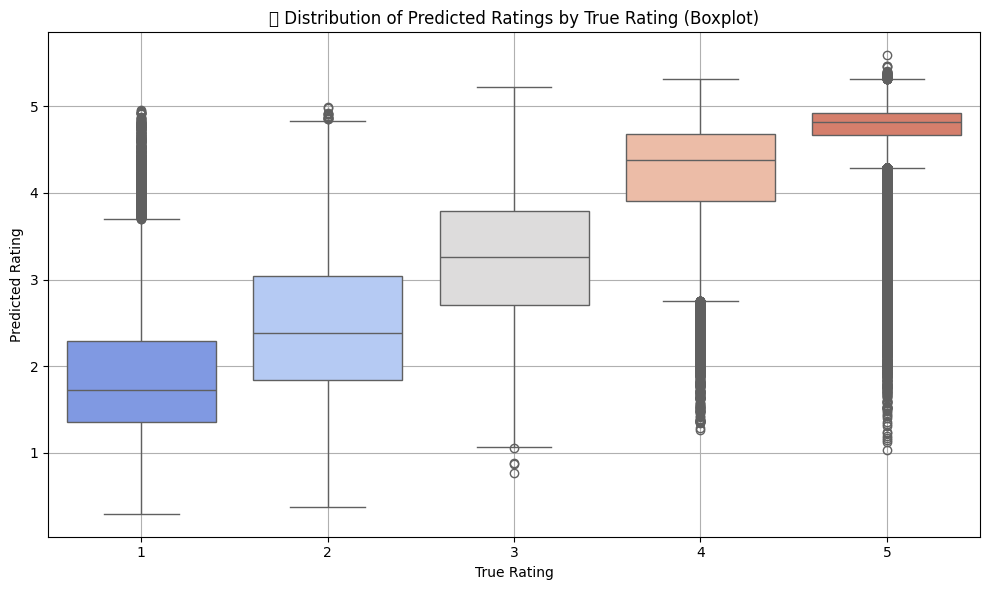

In [11]:
# 📦 Boxplot of predicted ratings for each true rating bucket

# Group predictions by the true rating
import pandas as pd
boxplot_df = pd.DataFrame({
    'True Rating': y_test,
    'Predicted Rating': y_pred.flatten()
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='True Rating', y='Predicted Rating', data=boxplot_df, palette='coolwarm')
plt.title("📦 Distribution of Predicted Ratings by True Rating (Boxplot)")
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.grid(True)
plt.tight_layout()
plt.show()
